In [1]:
import sys
import os
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt

# Add parent directory to path
sys.path.append('..')
sys.path.append('../tools')

# Add training modules
training_path = Path('../siren/training')
sys.path.append(str(training_path))

from dataset import PhotonSimDataset

current_dir = Path.cwd()
project_root = current_dir.parent  # diffCherenkov root (one level up from notebooks)
photonsim_root = project_root.parent / 'PhotonSim'  # PhotonSim root
h5_path = photonsim_root / 'output/3d_lookup_table_average' / 'photon_lookup_table.h5'

print(h5_path)

/sdf/home/c/cjesus/Dev/PhotonSim/output/3d_lookup_table_average/photon_lookup_table.h5


In [2]:
dataset = PhotonSimDataset(h5_path)

In [22]:
from tools.generate import generate_random_cone_vectors, normalize, photonsim_differentiable_get_rays
from tools.simulation import create_photonsim_siren_grid
import jax.numpy as jnp
from jax import random

# Import PhotonSim training modules
from inference import SIRENPredictor

energies = np.linspace(100,1000,100)
tot_real_photons = []
tot_pred_photons = []

model_base_path = Path('../notebooks/output/photonsim_siren_training/trained_model/photonsim_siren')
photonsim_predictor = SIRENPredictor(model_base_path)
table_data = create_photonsim_siren_grid(photonsim_predictor, 500)

# Set up simulation parameters this doesn't really matter
origin = jnp.array([0.5, 0.0, -0.5])
direction = jnp.array([1.0, -1.0, 0.2])
Nphot = 1_000_000
key = random.PRNGKey(0)
energy = 500
model_params = photonsim_predictor.params


for energy in energies:
    tot_real_photons.append(dataset.get_total_counts_for_energy(energy))
    _, _, photon_weights = photonsim_differentiable_get_rays(origin, direction, energy, Nphot, table_data, model_params, key)

    tot_pred_photons.append(np.sum(photon_weights))

Linear Fit Results:
Slope: 12.281581 ± 0.030575
Intercept: -781.924247
R-squared: 0.9994
Correlation coefficient (r): 0.9997
P-value: 1.91e-159
Standard error: 0.030575
Equation: y = 12.281581x + -781.924247


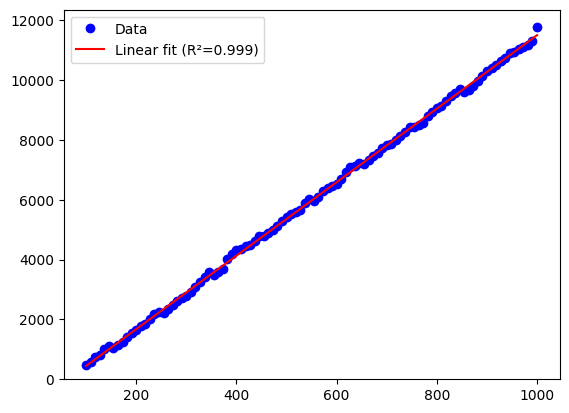

In [23]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt

# Your existing data
y_data = np.array(tot_real_photons)/(np.array(tot_pred_photons)/Nphot)

# Linear fit
slope, intercept, r_value, p_value, std_err = stats.linregress(energies, y_data)
line = slope * energies + intercept

# Print fitted parameters
print("Linear Fit Results:")
print(f"Slope: {slope:.6f} ± {std_err:.6f}")
print(f"Intercept: {intercept:.6f}")
print(f"R-squared: {r_value**2:.4f}")
print(f"Correlation coefficient (r): {r_value:.4f}")
print(f"P-value: {p_value:.2e}")
print(f"Standard error: {std_err:.6f}")
print(f"Equation: y = {slope:.6f}x + {intercept:.6f}")

plt.plot(energies, y_data, 'bo', label='Data')
plt.plot(energies, line, 'r-', label=f'Linear fit (R²={r_value**2:.3f})')
plt.gca().set_ylim(0)
plt.legend()
plt.show()

Linear Fit Results:
Slope: -0.000011 ± 0.000012
Intercept: 1.007402
R-squared: 0.0087
Correlation coefficient (r): -0.0932
P-value: 3.57e-01
Standard error: 0.000012
Equation: y = -0.000011x + 1.007402


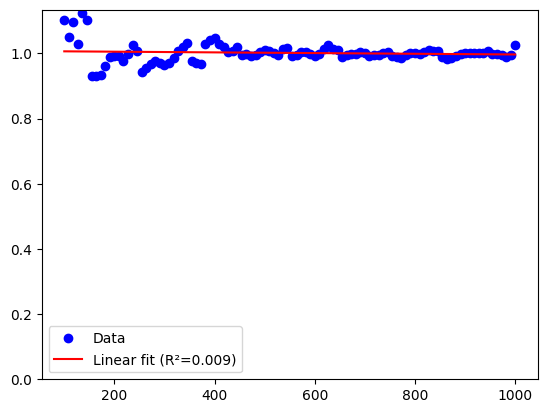

In [25]:
def corr_function(x):
    return 12.281581*x -781.924247

import numpy as np
from scipy import stats
import matplotlib.pyplot as plt

# Your existing data
y_data = np.array(tot_real_photons)/(corr_function(energies)*np.array(tot_pred_photons)/Nphot)

# Linear fit
slope, intercept, r_value, p_value, std_err = stats.linregress(energies, y_data)
line = slope * energies + intercept

# Print fitted parameters
print("Linear Fit Results:")
print(f"Slope: {slope:.6f} ± {std_err:.6f}")
print(f"Intercept: {intercept:.6f}")
print(f"R-squared: {r_value**2:.4f}")
print(f"Correlation coefficient (r): {r_value:.4f}")
print(f"P-value: {p_value:.2e}")
print(f"Standard error: {std_err:.6f}")
print(f"Equation: y = {slope:.6f}x + {intercept:.6f}")

plt.plot(energies, y_data, 'bo', label='Data')
plt.plot(energies, line, 'r-', label=f'Linear fit (R²={r_value**2:.3f})')
plt.gca().set_ylim(0)
plt.legend()
plt.show()